---
title: "Asset Allocation & Investment Strategies - 2nd Assignment"
author:
  - Group 1
  - Azim Balci, Mayeul Perret, Rodolphe Lajugie, Theodosis Kaplanidis, Zihua Du
date: "2026-02-02"
format: pdf
---
\newpage
\tableofcontents
\listoffigures
\listoftables
\newpage

## Importing Python Libraries and Statistical Packages

In [1]:
import pandas as pd
import numpy as np
import datetime
import statsmodels.api as sm
import matplotlib.pyplot as plt
import re

## Data Description and Loading


In this section, we load the two datasets used throughout the analysis.

The first dataset contains the monthly Fama–French risk factors and the risk-free rate.  It provides the market excess return (Mkt_RF), the size factor (SMB), the value factor (HML), and the one-month risk-free rate (RF). These variables are used as explanatory factors in the asset pricing regressions.

The second dataset contains the monthly excess returns of the 25 Fama–French portfolios formed on size and book-to-market equity. We focus on value-weighted portfolio returns, which serve as the dependent variables in the time-series regressions.

In [2]:
# Load value-weighted monthly portfolio returns
portfolios_vw = pd.read_excel(
    "25_Portfolios_5x5_clean.xlsx",
    sheet_name="VW Returns Monthly")

# Clean header structure
portfolios_vw = portfolios_vw.iloc[1:].reset_index(drop=True)
portfolios_vw.columns = portfolios_vw.iloc[0]
portfolios_vw = portfolios_vw.iloc[1:].reset_index(drop=True)
portfolios_vw["Date"] = pd.to_datetime(portfolios_vw["Date"])

# Convert portfolio returns from percent to decimal
portfolio_cols = [col for col in portfolios_vw.columns if col != "Date"]
for col in portfolio_cols:
    portfolios_vw[col] = pd.to_numeric(portfolios_vw[col]) / 100

# Load Fama-French factors data
ff_factors = pd.read_excel(
    "F-F_Research_Data_Factors_clean.xlsx",
    sheet_name="Monthly Excess Returns")

# Merge portfolios with risk-free rate
data = portfolios_vw.merge(
    ff_factors[["Date", "RF"]],
    on="Date",
    how="inner")

# Compute excess returns for each portfolio
for col in portfolio_cols:
    data[col] = data[col] - data["RF"]

# Keep excess portfolio returns only
excess_portfolios = data.drop(columns=["RF"])

## Sample Period and Data Preparation for the CAPM

We begin by evaluating the performance of the single-factor CAPM over the sample period studied by Fama and French (1993). Following the original analysis, we restrict the data to the period from January 1964 to January 1993.

The excess returns of the 25 Fama–French portfolios and the market excess return are used as inputs in the subsequent time-series regressions.

In [3]:
# Define sample period
start_date = "1964-01-01"
end_date = "1993-01-01"

# Restrict portfolio excess returns to the sample period
excess_portfolios_sample = excess_portfolios[
    (excess_portfolios["Date"] >= start_date) &
    (excess_portfolios["Date"] <= end_date)
].reset_index(drop=True)

# Restrict factor data to the same sample period
ff_factors_sample = ff_factors[
    (ff_factors["Date"] >= start_date) &
    (ff_factors["Date"] <= end_date)
].reset_index(drop=True)

# Keep market excess return only for CAPM
mkt_excess = ff_factors_sample[["Date", "Mkt_RF"]]

## Question i

We evaluate the performance of the single-factor CAPM by estimating, for each of the 25 Fama–French portfolios, the following time-series regression over the period January 1964 to January 1993:

$$
r_{i,t} = \alpha_i + \beta_i \, Mkt\_RF_t + \varepsilon_{i,t},
$$

where $r_{i,t}$ denotes the excess return on portfolio $i$ and $Mkt\_RF_t$ is the market excess return. For each portfolio, we report the mean excess return, the estimated CAPM beta and its t-statistic, the estimated alpha and its t-statistic, and the adjusted $R^2$.

In [4]:
#| tbl-cap: "CAPM Results for the 25 Fama–French Portfolios (1964–1993)"
# Run CAPM time-series regressions for the 25 portfolios

# Merge portfolio excess returns with market excess return
reg_data = excess_portfolios_sample.merge(
    ff_factors_sample[["Date", "Mkt_RF"]],
    on="Date",
    how="inner")

# Identify portfolio columns
portfolio_cols = [col for col in reg_data.columns if col not in ["Date", "Mkt_RF"]]

# Container for regression results
results = []

# Loop over portfolios and estimate CAPM regressions
for col in portfolio_cols:
    y = reg_data[col]
    X = sm.add_constant(reg_data["Mkt_RF"])
    model = sm.OLS(y, X).fit()
    
    results.append({
        "Portfolio": col,
        "Mean Excess Return": y.mean(),
        "Beta": model.params["Mkt_RF"],
        "Beta t-stat": model.tvalues["Mkt_RF"],
        "Alpha": model.params["const"],
        "Alpha t-stat": model.tvalues["const"],
        "Adj. R2": model.rsquared_adj
    })

# Collect results in a DataFrame
capm_results = pd.DataFrame(results)
capm_results

,Portfolio,Mean Excess Return,Beta,Beta t-stat,Alpha,Alpha t-stat,Adj. R2
0,SMALL LoBM,0.003090,1.425884,27.798851,-0.002637,-1.126317,0.689224
1,ME1 BM2,0.007425,1.250530,28.182754,0.002403,1.186556,0.695076
2,ME1 BM3,0.007840,1.158853,28.657677,0.003186,1.726040,0.702122
3,ME1 BM4,0.009437,1.077028,26.867342,0.005112,2.793956,0.674418
4,SMALL HiBM,0.010844,1.103020,24.185137,0.006414,3.081514,0.626578
5,ME2 BM1,0.004047,1.428427,37.147215,-0.001689,-0.962518,0.798485
6,ME2 BM2,0.006582,1.234521,37.442397,0.001625,1.079549,0.801022
7,ME2 BM3,0.008828,1.116015,35.597026,0.004346,3.037569,0.784406
8,ME2 BM4,0.009565,1.033107,34.744860,0.005416,3.991288,0.776091
9,ME2 BM5,0.010755,1.123314,30.086892,0.006243,3.663913,0.722094


In [5]:
#| tbl-cap: "Mean Excess Returns of the 25 Fama–French Portfolios (1964–1993)"
#| label: tbl-excess-returns

# Create robust 5x5 tables (no NaN) using strict portfolio name mapping

size_map = {"1": "Small", "2": "2", "3": "3", "4": "4", "5": "Big"}
bm_map = {"1": "Low", "2": "2", "3": "3", "4": "4", "5": "High"}

def parse_portfolio_strict(name):
    if name.startswith("SMALL"):
        return "Small", ("Low" if "LoBM" in name else "High")
    if name.startswith("BIG"):
        return "Big", ("Low" if "LoBM" in name else "High")
    m = re.match(r"ME(\d)\s+BM(\d)", name)
    if m:
        return size_map[m.group(1)], bm_map[m.group(2)]
    return pd.NA, pd.NA

capm_results[["Size", "BM"]] = capm_results["Portfolio"].apply(
    lambda x: pd.Series(parse_portfolio_strict(x))
)

size_order = ["Small", "2", "3", "4", "Big"]
bm_order = ["Low", "2", "3", "4", "High"]

def make_5x5(var):
    out = capm_results.pivot(index="Size", columns="BM", values=var)
    return out.loc[size_order, bm_order]

mean_5x5   = make_5x5("Mean Excess Return")
beta_5x5   = make_5x5("Beta")
beta_t_5x5 = make_5x5("Beta t-stat")
alpha_5x5  = make_5x5("Alpha")
alpha_t_5x5= make_5x5("Alpha t-stat")
r2_5x5     = make_5x5("Adj. R2")
mean_5x5

BM,Low,2,3,4,High
Size,,,,,
Small,0.003090,0.007425,0.007840,0.009437,0.010844
2,0.004047,0.006582,0.008828,0.009565,0.010755
3,0.004491,0.006975,0.007049,0.008792,0.010202
4,0.004657,0.004035,0.006177,0.008066,0.009194
Big,0.003263,0.003467,0.003490,0.005139,0.006125


In [6]:
#| tbl-cap: "CAPM Betas for the 25 Fama–French Portfolios (1964–1993)"
#| label: tbl-betas
beta_5x5

BM,Low,2,3,4,High
Size,,,,,
Small,1.425884,1.250530,1.158853,1.077028,1.103020
2,1.428427,1.234521,1.116015,1.033107,1.123314
3,1.353789,1.162876,1.033577,0.975694,1.069104
4,1.223638,1.128797,1.034855,0.973928,1.081046
Big,1.001999,0.982546,0.866932,0.834828,0.870462


In [7]:
#| tbl-cap: "t-Statistics of CAPM Betas for the 25 Fama–French Portfolios (1964–1993)"
# | label: tbl-betas-t-stats
beta_t_5x5

BM,Low,2,3,4,High
Size,,,,,
Small,27.798851,28.182754,28.657677,26.867342,24.185137
2,37.147215,37.442397,35.597026,34.744860,30.086892
3,45.604053,45.617558,41.500499,39.040635,30.741266
4,55.263285,57.108716,49.793979,39.517688,33.602720
Big,49.686748,58.557294,40.036931,36.661585,26.605966


In [8]:
#| tbl-cap: "CAPM Alphas for the 25 Fama–French Portfolios (1964–1993)"
#| label: tbl-alphas
alpha_5x5

BM,Low,2,3,4,High
Size,,,,,
Small,-0.002637,0.002403,0.003186,0.005112,0.006414
2,-0.001689,0.001625,0.004346,0.005416,0.006243
3,-0.000945,0.002305,0.002898,0.004873,0.005908
4,-0.000257,-0.000498,0.002021,0.004155,0.004853
Big,-0.000761,-0.000479,0.000008,0.001786,0.002629


In [9]:
#| tbl-cap: "t-Statistics of CAPM Alphas for the 25 Fama–French Portfolios (1964–1993)"
#| label: tbl-alphas-t-stats
alpha_t_5x5

BM,Low,2,3,4,High
Size,,,,,
Small,-1.126317,1.186556,1.726040,2.793956,3.081514
2,-0.962518,1.079549,3.037569,3.991288,3.663913
3,-0.697838,1.981224,2.549935,4.272519,3.722447
4,-0.254490,-0.552534,2.130326,3.693725,3.305077
Big,-0.826358,-0.625438,0.008073,1.718931,1.760606


In [10]:
#| tbl-cap: "CAPM R-squared for the 25 Fama–French Portfolios (1964–1993)"
#| label: tbl-r2
r2_5x5

BM,Low,2,3,4,High
Size,,,,,
Small,0.689224,0.695076,0.702122,0.674418,0.626578
2,0.798485,0.801022,0.784406,0.776091,0.722094
3,0.856597,0.856670,0.831826,0.814020,0.730655
4,0.897678,0.903559,0.876877,0.817672,0.764250
Big,0.876410,0.907838,0.821534,0.794213,0.670104


# Question ii

@tbl-excess-returns reveals two distinct patterns in portfolio returns. Moving east (from low to high B/M, i.e. from growth to value stocks), we observe a consistent and pronounced increase in excess returns across virtually all size categories. For small-cap stocks, for example, returns increase from 0.31% for growth stocks to 1.08% for value stocks, representing a 3.5-fold increase. For large-cap stocks, the increase is more modest (from 0.33% to 0.61%), but still consistent. This value premium is remarkably persistent, indicating that the B/M ratio is the dominant driver of returns.

However, moving south (from small to large firms), the effect is far less consistent. Small-cap value stocks achieve returns of 1.08%, compared to 0.61% for large-cap value stocks. Yet within the growth category (low B/M), small-cap and large-cap returns are almost identical (0.31% vs 0.33%). For mid-cap stocks, the patterns are muddled, with returns peaking in the middle size categories rather than at the extremes.

The data strongly suggests that the value premium dominates the size effect. The highest returns cluster in the north-east quadrant (small value stocks: 1.08%), while the lowest are in the south-west (large growth stocks: 0.33%). This indicates that investors are rewarded far more consistently for the value premium than for the size premium.

# Question iii

To answer this question, we examined the recorded β values from our OLS model, which are shown in @tbl-betas. The data reveals an important asymmetry: value stocks have consistently lower betas than growth stocks, yet earn higher average returns. This directly contradicts the CAPM prediction that returns should be proportional to systematic risk.

By contrast, the size effect may be reconcilable with CAPM to some extent: small-cap stocks typically have higher betas and also earn higher returns, which is consistent with them being compensated for greater market risk.

However, the value premium presents a genuine puzzle. Value stocks (high B/M) have lower market risk exposure (lower beta) than growth stocks yet consistently deliver higher returns across all size categories. According to Markowitz's mean-variance framework and CAPM, investors should be compensated for bearing risk, i.e. safer assets should earn lower returns. However, the safest stocks within each size category actually earn the highest returns.

This pattern suggests that beta alone is insufficient to explain the cross-section of returns. Additional systematic risk factors, such as value and size, appear to be priced by the market independently of market beta. This empirical finding directly motivated the development of multi-factor asset pricing models, such as the Fama-French model.

# Question iv

Looking at @tbl-alphas-t-stats, we can compare the value of each alpha versus the standard critical value for a 95% confidence level, which is 1.69.
In our case, several alphas are highly significant, particularly those from mid & high book to market ratio. In the context of CPAM, $\alpha$ represents the excess return - in other words, the return that cannot be explained by the market factor. Having said that, knowing that 12 out of 25 of the alphas calculated are significant at a 95% confidence level reveals that those portfolios "beat" the market earning abnormal returns relative to the amount of market risk they carry.

Regarding the $R^2$, they are quite high (from 0.63 to 0.91) based on the results from @tbl-r2. However we can see that they are decreasing as the book to market ratio is going high. It therefore suggest that the market factor explains a very large portion (63% to 91%) of the time series variation in portfolio returns.

From what we've seen, we can conclude that the CAPM is good at explaining why returns movu up and down over time, however the significant alphas prove it is poor at explaining the average level of those returns 

# Question v

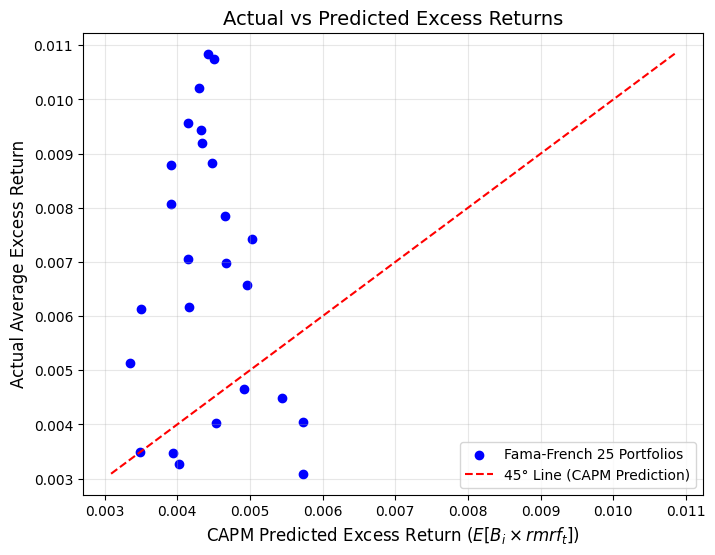

In [11]:
# | tbl-cap: "Actual vs Predicted Excess Returns"
# | label: tbl-actual-vs-predicted-exc-returns

# Predicted Returns
mkt_mean_excess = reg_data["Mkt_RF"].mean()
capm_results["Predicted Return"] = capm_results["Beta"] * mkt_mean_excess

plt.figure(figsize=(8, 6))
plt.scatter(capm_results["Predicted Return"],
            capm_results["Mean Excess Return"],
            color='blue', label='Fama-French 25 Portfolios')

min_val = min(capm_results["Predicted Return"].min(),
              capm_results["Mean Excess Return"].min()) # for 45° line
max_val = max(capm_results["Predicted Return"].max(),
              capm_results["Mean Excess Return"].max()) # for 45° line
line_coords = np.linspace(min_val, max_val, 100)
plt.plot(line_coords, line_coords, color='red',
         linestyle='--', label='45° Line (CAPM Prediction)') # plot the 45° line

plt.xlabel(
    'CAPM Predicted Excess Return ($E[B_i \\times rmrf_t]$)', fontsize=12)
plt.ylabel('Actual Average Excess Return', fontsize=12)
plt.title('Actual vs Predicted Excess Returns', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)

The graph above clear shows that the model is not good at explaining cross-sectional returns.<br>
Indeed, if the CAPM was accurate, all the blue dots would lie on the 45° line (the red one). We can also try to compare actual vs predicted:
- predicted returns rely between 0.35% and 0.55% 
- actual returns are more spread, from 0.3% to 1.1% 

# Question vi

Our findings indicate that while the CAPM retains some practical value, its explanatory power is fundamentally incomplete. 

In the time series, the model performs relatively well: the market factor alone accounts for a large share of the month‑to‑month variation in returns, with adjusted R-Squared values range between roughly 0.67 and 0.91 across the 25 portfolios. This suggests that market risk remains an important driver of short‑run return dynamics. However, when shifting to the cross‑section—where the model’s core prediction is that differences in average returns should correspond to differences in beta—the empirical evidence clearly contradicts the CAPM. 

Betas vary only modestly across the portfolios, which produces a narrow range of predicted excess returns, while the actual mean excess returns are far more dispersed. This mismatch is confirmed by the fact that 12 out of 25 alphas are statistically significant at conventional levels, indicating systematic pricing errors rather than noise. 
The most severe failure concerns the value portfolios: high book‑to‑market portfolios earn consistently higher returns despite having lower market betas than growth portfolios, directly violating the CAPM’s risk‑return trade‑off. 

Nonetheless, the model is not entirely irrelevant—roughly half of the portfolios display insignificant alphas, implying that in some cases beta alone remains a reasonable approximation of expected returns. 

In the graph of Average Excess Return vs. CAPM Predicted Excess Return, if CAPM is correct, we should see that all portfolios lie are located on or close to the 45-degree line. However, in reality, most of them deviate greatly from the straight line, indicating that there is a considerable difference between the predicted returns of CAPM and the actual returns. A single factor of market premium is insufficient to explain the returns. There should be other factors that account for the variation of portfolio returns.

Overall, the CAPM has limited “hope”: it remains useful as a baseline and for understanding time‑series co‑movements, but it cannot explain the cross‑sectional structure of expected returns in the Fama–French 25 portfolios. To capture these return patterns, additional priced factors—such as size and value—are clearly required.

# Question vii

In [12]:
def capm_results_for_sample(start_date, end_date):
    # filter returns data based on the date chosen
    excess_portfolios_q9 = excess_portfolios[
        (excess_portfolios["Date"] >= start_date) &
        (excess_portfolios["Date"] <= end_date)
    ].copy()

    # filter factor data based on the date chosen (need Mkt_RF)
    factors_q9 = ff_factors[
        (ff_factors["Date"] >= start_date) &
        (ff_factors["Date"] <= end_date)
    ][["Date", "Mkt_RF"]].copy()

    # merge to one data frame and align dates
    reg_s = excess_portfolios_q9.merge(factors_q9, on="Date", how="inner")

    # run CAPM regressions portfolio-by-portfolio
    results = []
    for col in portfolio_cols:
        y = reg_s[col]
        X = sm.add_constant(reg_s["Mkt_RF"])
        model = sm.OLS(y, X).fit()

        results.append({
            "Portfolio": col,
            "Mean Excess Return": float(y.mean()),
            "Beta": float(model.params["Mkt_RF"]),
            "Beta t-stat": float(model.tvalues["Mkt_RF"]),
            "Alpha": float(model.params["const"]),
            "Alpha t-stat": float(model.tvalues["const"]),
            "Adj. R2": float(model.rsquared_adj)
        })

    capm_res = pd.DataFrame(results)
    return capm_res, reg_s


def plot_actual_vs_predicted(capm_res, reg_s, title):
    mkt_mean_excess = float(reg_s["Mkt_RF"].mean())
    # predicted = beta * market excess return
    capm_res["Predicted Return"] = capm_res["Beta"] * mkt_mean_excess

    # plot the dots for each portfolio
    plt.figure(figsize=(8, 6))
    plt.scatter(capm_res["Predicted Return"], capm_res["Mean Excess Return"], label="Fama-French 25 Portfolios")

    min_val = min(capm_res["Predicted Return"].min(), capm_res["Mean Excess Return"].min())
    max_val = max(capm_res["Predicted Return"].max(), capm_res["Mean Excess Return"].max())
    line_coords = np.linspace(min_val, max_val, 100)
    plt.plot(line_coords, line_coords, linestyle="--", label="45° Line (CAPM)")

    plt.xlabel(r"CAPM Predicted Excess Return ($E[\beta_i \times mktrf_t]$)")
    plt.ylabel("Actual Average Excess Return")
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()


In [13]:
size_order = ["Small", "2", "3", "4", "Big"]
bm_order   = ["Low", "2", "3", "4", "High"]

bm_label = {"Low": "BM1", "2": "BM2", "3": "BM3", "4": "BM4", "High": "BM5"}
size_label = {"Small": "ME1", "2": "ME2", "3": "ME3", "4": "ME4", "Big": "ME5"}

In [14]:
capm_results_64to93, reg_data_64to93 = capm_results_for_sample("1964-01-01", "1993-01-01")

In [15]:
def prepare_pred_vs_actual(capm_res, reg_s):
    capm_res = capm_res.copy()

    # add predicted return (same as your code)
    mkt_mean_excess = float(reg_s["Mkt_RF"].mean())
    capm_res["Predicted Return"] = capm_res["Beta"] * mkt_mean_excess

    # add size and bm labels
    capm_res[["Size", "BM"]] = capm_res["Portfolio"].apply(
        lambda x: pd.Series(parse_portfolio_strict(x))
    )

    return capm_res

In [16]:
# this function helps label portfolios on plots
def label_point(x, y, text, dx=6, dy=6, fontsize=9):
    plt.annotate(
        text,
        xy=(x, y),
        textcoords="offset points",
        xytext=(dx, dy),
        ha="left",
        fontsize=fontsize
    )

In [17]:
def plot_pred_vs_actual_connect_bm(capm_res, reg_s, title):
    df = prepare_pred_vs_actual(capm_res, reg_s)

    plt.figure(figsize=(8, 6))

    # scatter all points first
    plt.scatter(df["Predicted Return"], df["Mean Excess Return"])

    # connect within each BM (5 lines)
    for bm in bm_order:
        sub = df[df["BM"] == bm].copy()
        sub["Size"] = pd.Categorical(sub["Size"], categories=size_order, ordered=True)
        sub = sub.sort_values("Size")

        plt.plot(sub["Predicted Return"], sub["Mean Excess Return"], 
                 marker="o", linewidth=1, label=bm_label[bm])
        
        # we plot only the endpoints in each group
        first = sub.iloc[0]   # Small end
        last  = sub.iloc[-1]  # Big end

        label_point(first["Predicted Return"], first["Mean Excess Return"], first["Portfolio"], dx=6, dy=6)
        label_point(last["Predicted Return"],  last["Mean Excess Return"],  last["Portfolio"],  dx=6, dy=6)

    # 45-degree line y=x
    min_val = min(df["Predicted Return"].min(), df["Mean Excess Return"].min())
    max_val = max(df["Predicted Return"].max(), df["Mean Excess Return"].max())
    line_coords = np.linspace(min_val, max_val, 100)
    plt.plot(line_coords, line_coords, linestyle="--", label="45° Line (CAPM)")


    plt.xlabel(r"CAPM Predicted Excess Return ($E[\beta_i \times mktrf_t]$)")
    plt.ylabel("Actual Average Excess Return")
    plt.title(title + " — connect within B/M")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

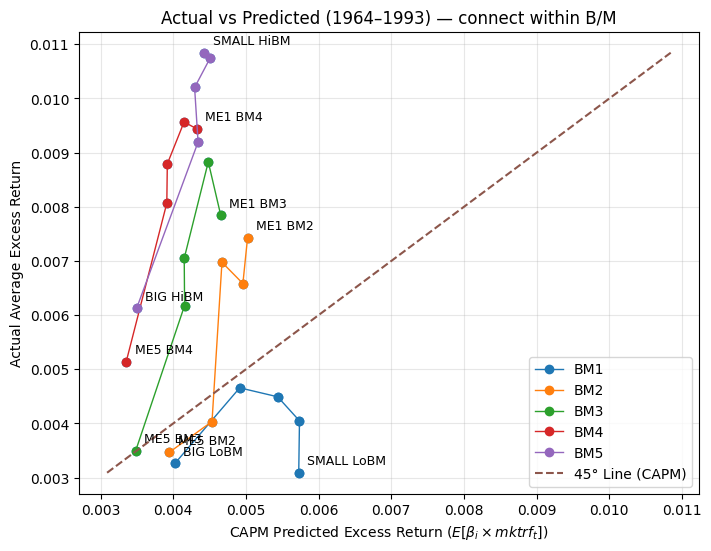

In [18]:
plot_pred_vs_actual_connect_bm(
    capm_results_64to93,
    reg_data_64to93,
    "Actual vs Predicted (1964–1993)"
)

We see in figure that there is a weak to moderate positive relationship between CAPM predicted excess return and average excess return within each B/M category. As you move from left to right (increasing CAPM predicted returns), actual returns generally increase. However, the relationship is not tight and the lines show considerable scatter, especially for growth stocks (Low B/M). 

We see that the category of high B/M ratio, such as BM5, locate above than those with low B/M ratio. Higher B/M ratio may generally suggest a higher return.

Additionally, we plot the endpoints of each B/M category and notice that within the same B/M category, the actual return increases as the size of the portfolio decreases. It is then evident that size matters within B/M groups (small portfolios tend to have higher average returns), but the pattern is not fully captured by the CAPM; this is consistent with the idea that additional factors such as size (SMB) may be needed.

# Question viii

In [19]:
def plot_pred_vs_actual_connect_size(capm_res, reg_s, title):
    df = prepare_pred_vs_actual(capm_res, reg_s)

    plt.figure(figsize=(8, 6))

    # scatter all points first
    plt.scatter(df["Predicted Return"], df["Mean Excess Return"])

    # connect within each Size (5 lines)
    for sz in size_order:
        sub = df[df["Size"] == sz].copy()
        sub["BM"] = pd.Categorical(sub["BM"], categories=bm_order, ordered=True)
        sub = sub.sort_values("BM")

        plt.plot(sub["Predicted Return"], sub["Mean Excess Return"], 
                 marker="o", linewidth=1, label=size_label[sz])

        # we plot only the endpoints in each group
        first = sub.iloc[0]   # Small end
        last  = sub.iloc[-1]  # Big end

        label_point(first["Predicted Return"], first["Mean Excess Return"], first["Portfolio"], dx=6, dy=6)
        label_point(last["Predicted Return"],  last["Mean Excess Return"],  last["Portfolio"],  dx=6, dy=6)


    # 45-degree line y=x
    min_val = min(df["Predicted Return"].min(), df["Mean Excess Return"].min())
    max_val = max(df["Predicted Return"].max(), df["Mean Excess Return"].max())
    line_coords = np.linspace(min_val, max_val, 100)
    plt.plot(line_coords, line_coords, linestyle="--", label="45° Line (CAPM)")

    plt.xlabel(r"CAPM Predicted Excess Return ($E[\beta_i \times mktrf_t]$)")
    plt.ylabel("Actual Average Excess Return")
    plt.title(title + " — connect within Size")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

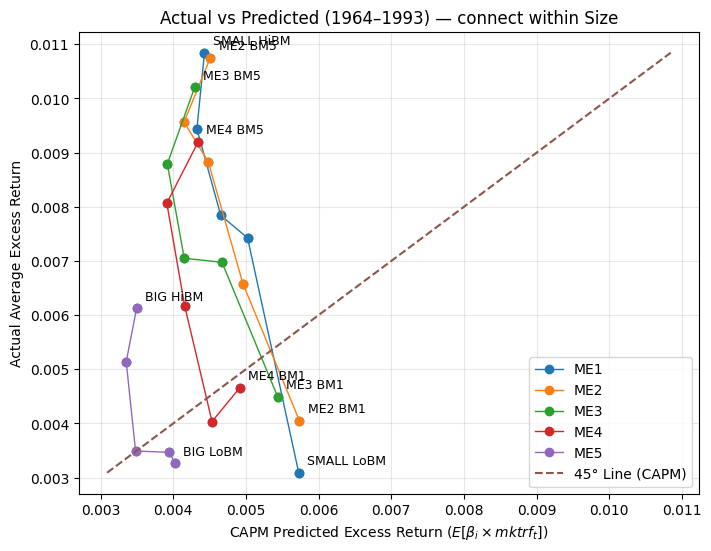

In [20]:
plot_pred_vs_actual_connect_size(
    capm_results_64to93,
    reg_data_64to93,
    "Actual vs Predicted (1964–1993)"
)

We see in figure that there is a very weak or almost no relationship between CAPM predicted excess return and average excess return within each size category. The lines are nearly downward-sloping (e.g., ME5 and ME4 categories), which directly contradicts CAPM's prediction. The graph indicates that as CAPM predicted returns increase, the actual returns do not necessarily increase and even decrease, likely due to factors other than market premium. Moreover, inside each size category, we note that the end points representing high B/M ratio all locating above those representing low B/M ratio, indicating a value effect and the corresponding factor (HML) not explained by CAPM. Portfolio composed of companies with high B/M ratio (value stock) may suggest a higher return, as they carry higher financial risk in economic downturn, offering higher premiums for compensation.

Overall, the graphs reveal that the positive relationship between CAPM's predicted excess returns and actual average excess returns largely fails to materialize in the cross-section of these 25 portfolios. Portfolios with higher book-to-market ratios earn substantially higher returns despite having similar or even lower betas than growth stocks. This is the core evidence that beta alone cannot explain expected returns, and additional factors (value and size) must be priced by the market.

# Question ix

In [21]:
# for 1/1933–12/1963
capm_results_33to63, reg_data_33to63 = capm_results_for_sample("1933-01-01", "1963-12-31")

# for 1/1933–12/2023
capm_results_33to23, reg_data_33to23 = capm_results_for_sample("1933-01-01", "2023-12-31")

## Part (a): 1/1933–12/1963

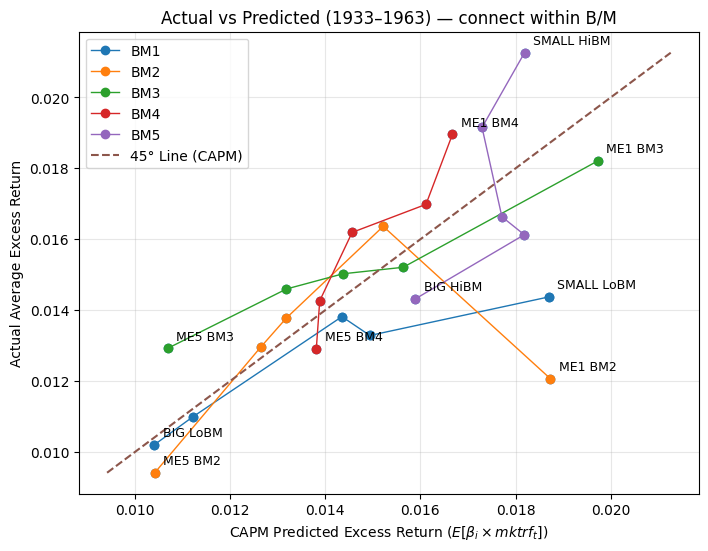

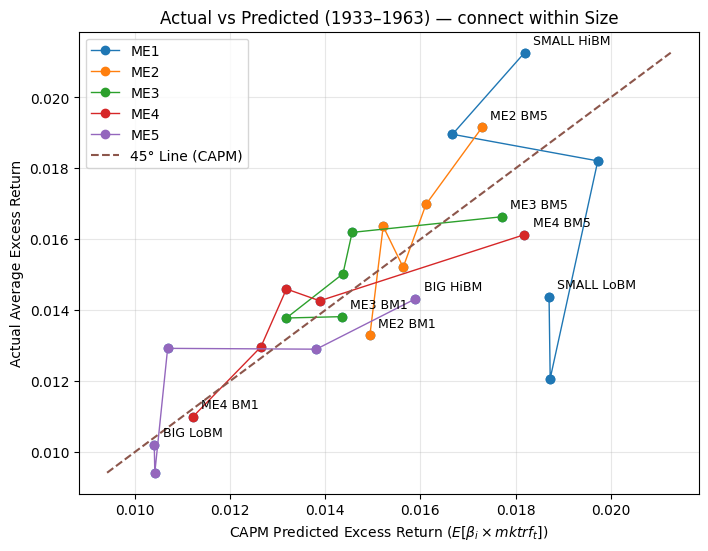

In [22]:
# 1933–1963
plot_pred_vs_actual_connect_bm(capm_results_33to63, reg_data_33to63,
                               "Actual vs Predicted (1933–1963)")
plot_pred_vs_actual_connect_size(capm_results_33to63, reg_data_33to63,
                                 "Actual vs Predicted (1933–1963)")


For the sample of 1933-1963, it suggests CAPM has "more hope" as the portfolios are closer to the 45-degree line overall than in the 1964-1993 plot, where many dots are far away from the line. However, it does not mean CAPM can effectively explain the returns, as there is still substaintial dispersion. Some categories of mid B/M or mid size are closely parallel to the 45-degree line. Their actual returns are generally close to the CAPM predicted returns. Nevertheless, categories like ME1 show a clear deviation, reducing the predicatability of CAPM.

In 1964–1993, when categorising with B/M, the separation by B/M is very strong and clearly violates CAPM. In 1933-1963, the situation still exists but is less extreme. 

In 1964-1993, when categorising with size, the plot shows a clear violation of CAPM, as the lines representing those categories are negatively sloped. The situation is, again, less extreme in the sample of 1933-1963. 

The sample of 1933-1963 seems to provide a result more consistent with CAPM prediction. This is likely due to several factors: stock returns during this time were more strongly driven by market premium; investment strategies were relatively simple; there were relatively few derivatives, making smaller impact on market fluctuations. In contrast, since the mid-1960s, financial information has been widely accessible, increasing the investment activities, and the size and value effects have emerged, generating clear return spreads that unexplained by market beta. This might explain why the samples of 1964-1993 were more inconsistent with CAPM results. Therefore, the relative consistency of 1933-1963 sample result with CAPM prediction should reflect be attributed to a simpler risk environment rather than the true effectiveness of the model.

In both sample periods, we can see that CAPM falls short in explaining the returns of portfolios. Inside each B/M category, portfolios with small-size companies generally produce higher returns. Inside each size category, portfolios with high B/M ratio gives the higher returns. The effects of size and value on portfolio returns cannot be fully captured by CAPM, which predicts solely based on market premium. 

## Part (b): 1/1933–12/2023

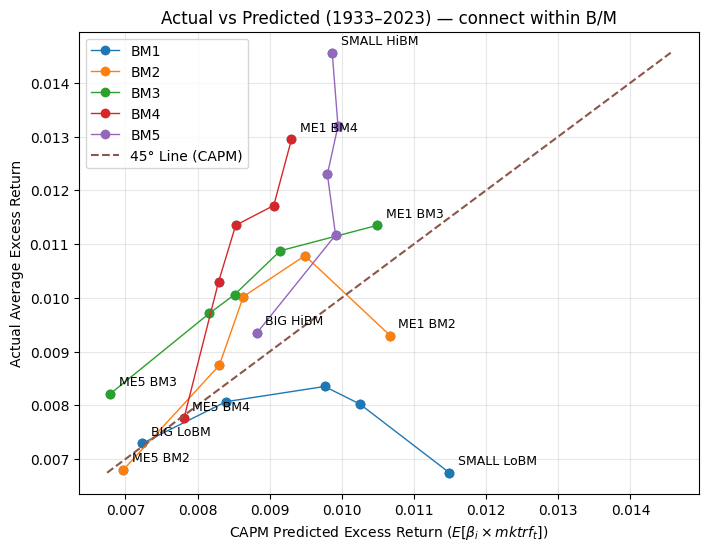

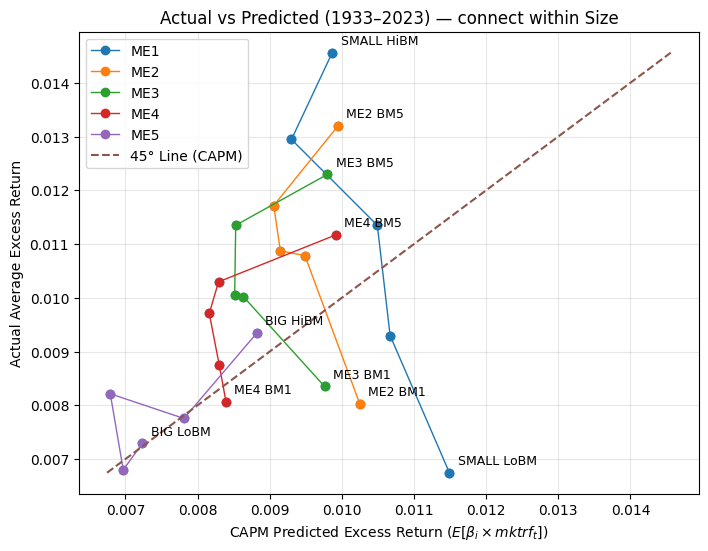

In [23]:
# 1933–2023
plot_pred_vs_actual_connect_bm(capm_results_33to23, reg_data_33to23,
                               "Actual vs Predicted (1933–2023)")
plot_pred_vs_actual_connect_size(capm_results_33to23, reg_data_33to23,
                                 "Actual vs Predicted (1933–2023)")

The long sample of 1933-2023 makes the failure in prediction of CAPM more systematic. Compared to 1933-1963 and 1964-1993 samples, here many portfolios clearly deviate from the 45-degree line. There is generally no cateogories with lines parallel to the 45-degree line. Low B/M points (BM1) generally sit on the lower side of the plot, and those with higher B/M (BM5) frequently sit above, with actual returns higher than what CAPM predicts. The situation becomes more extreme in long sample than the previous short-period samples. 

When categorising with B/M, the separation by B/M is strong. When categorising with size, the plot shows a clear violation of CAPM, as the lines representing those categories are negatively sloped. In both cases, the sample of 1933-2023 shows the plots similar to those provided by sample of 1964-1993, where extreme inconsistencies between CAPM prediction and actual returns are seen.

The sample data of 1933-2023 are generally less supportive of CAPM's prediction than those of 1964-1993. This might be due to the assumption of CAPM, which takes the beta to be constant across the sample time interval, while the beta actually keeps changing along with the market situation. This shortfall becomes particularly evident when the sample time increases, making the predicted returns deviate even more from actual returns.

Again, we show that CAPM falls short in explaining the returns of portfolios. Inside each B/M category, portfolios with small-size companies generally produce higher returns. Inside each size category, portfolios with high B/M ratio gives the higher returns. We've seen that the effect of size and value on returns exists across three samples of different time span, making the introduction of Fama French models, which cover additional factors like SMB and HML, becomes necessary in the purpose of improving the prediction of portfolio returns. 